In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import warnings; warnings.simplefilter('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose #dekompozice trendu, sezonosti atd
from statsmodels.tsa.stattools import acf, pacf #autokorelacni funkce
from statsmodels.tsa.ar_model import AutoReg,ar_select_order #AR parametry a odhad

from statsmodels.tsa.arima.model import ARIMA #ARIMA model
from statsmodels.tsa.stattools import arma_order_select_ic #ARMA parametry

import pmdarima as pm #ARIMA parametry

In [2]:
fn = 'https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/orp.csv'
data = pd.read_csv(fn, index_col=0, parse_dates=True)
data = data[data['orp_nazev']=="Tábor"]
data['datum'] = pd.to_datetime(data['datum'])
data = data.set_index('datum')

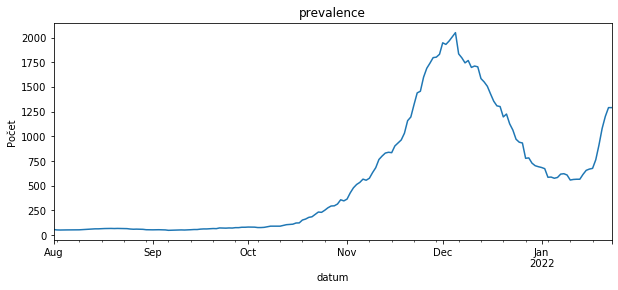

In [3]:
column="prevalence" #incidence_7 prevalence aktualni_pocet_hospitalizovanych_osob nove_hosp_7 testy_7
df=data[column].last('6M')
df = df.asfreq('D')
df.plot(figsize=(10,4))
plt.title(column)
plt.ylabel('Počet')
plt.show()

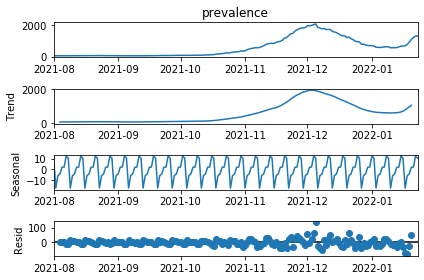

In [4]:
def seasonal_dc(df, period=7):
    sd = seasonal_decompose(df, period=period, model='additive') #takhle jsou rezidua nezavisla
    sd.plot()
    plt.show()
    return sd
sd = seasonal_dc(df, 7)

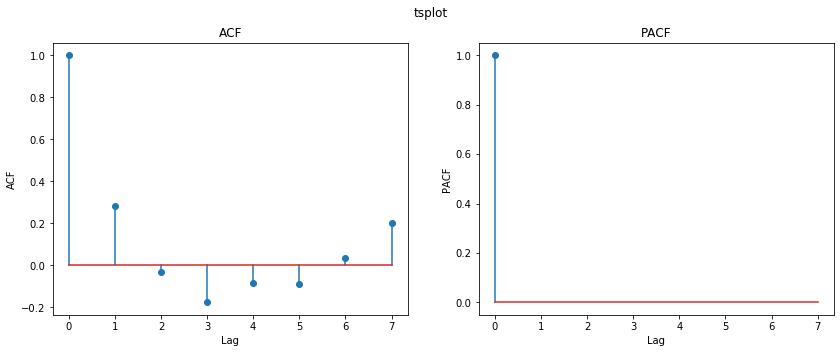

Suma kvadrátů reziduí ACF: 1.1706274579765772


In [5]:
def tsplot(dta, lags = 7):
    dta_acf = acf(dta, nlags=lags, missing='drop')
    dta_pacf = pacf(dta, nlags=lags)
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.stem(dta_acf)
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title('ACF')
    plt.subplot(122)
    plt.stem(dta_pacf)
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.title('PACF')
    plt.suptitle("tsplot")
    plt.show()
    return np.sum(dta_acf**2)

sum_of_squares_resid_acf = tsplot(sd.resid)
print('Suma kvadrátů reziduí ACF:', sum_of_squares_resid_acf)

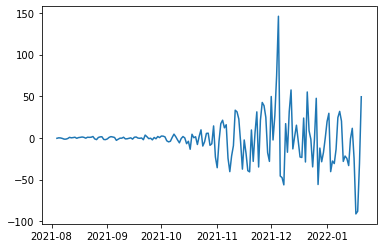

In [100]:
detrended = df - sd.trend
plt.plot(detrended)

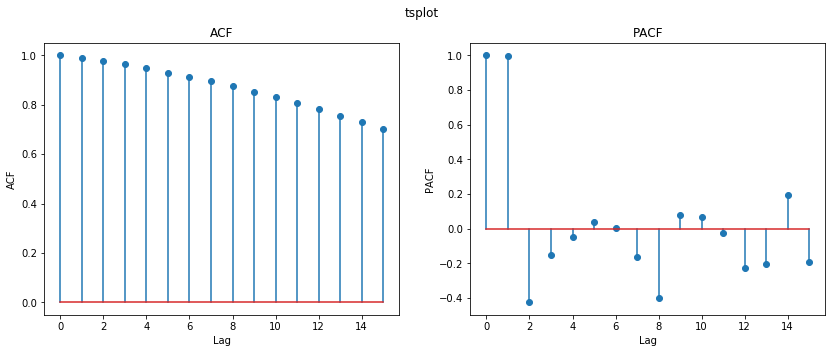

12.302428560720445

In [7]:

tsplot(df, 15) #vypada na nahodnou prochazku

Doporucene rady AR:  [1, 2, 3, 4, 5, 6, 7, 8]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             prevalence   No. Observations:                  176
Model:                     AutoReg(1)   Log Likelihood                -921.075
Method:               Conditional MLE   S.D. of innovations             46.728
Date:                Sun, 23 Jan 2022   AIC                           1848.149
Time:                        20:51:46   BIC                           1857.644
Sample:                    08-02-2021   HQIC                          1852.001
                         - 01-23-2022                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.5544      4.858      1.555      0.120      -1.967      17.075
prevalence.L1     0.9991      0.006    167.922      0.000       0.987       1.011
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0009           +0.0000j            1.0009            0.0000
-----------------------------------------------------------------------------
"""

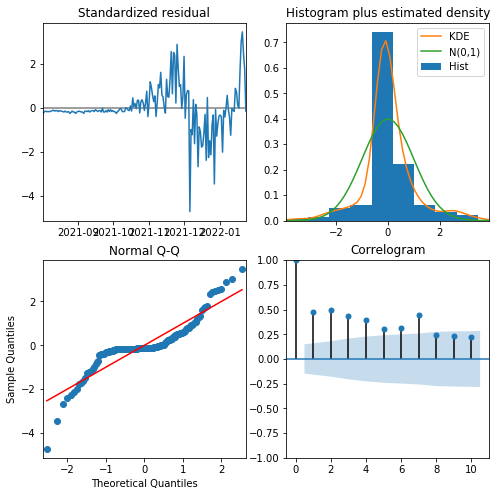

In [8]:
out = ar_select_order(df, maxlag=10, ic='bic', trend='c') #moc mi nerekne
print("Doporucene rady AR: ", out.ar_lags)
res = AutoReg(df, lags = 1, trend='c').fit()
b = res.params
display(res.summary())
res.plot_diagnostics(figsize=(8,8)) #porad jsou rezidua celkem korelovana
plt.show()

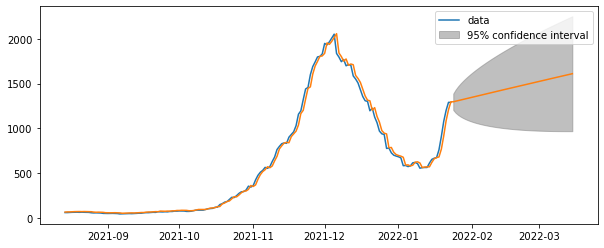

In [9]:
pred_from = '2021-08-14' #ndat - 100
ndat= len(df)
fcast_horizon = 50
fig = plt.figure(figsize=(10,4))
plt.plot(df[pred_from:], label='data')
res.plot_predict(pred_from, ndat+fcast_horizon, fig=fig)
plt.show()

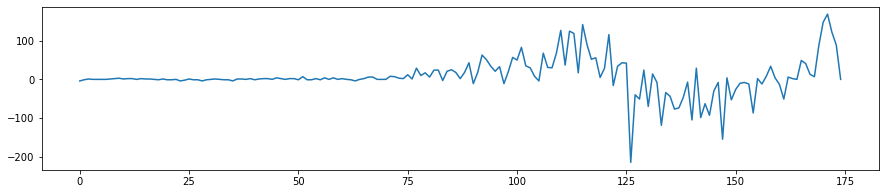

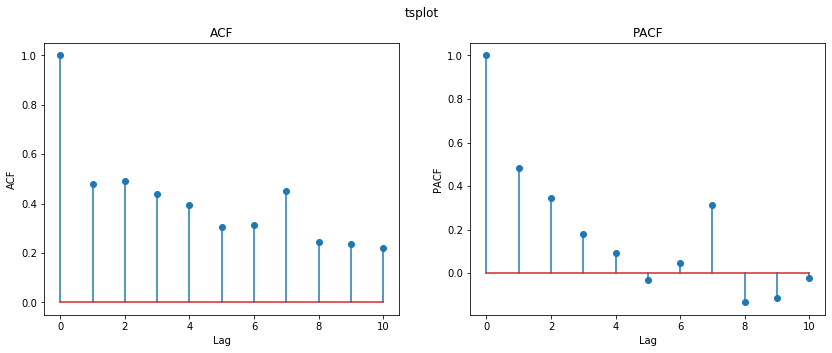

2.3792655733338264

In [98]:
#diference
def difference(df, n_diff=1):
    if n_diff == 0:
        return df
    return difference(df[1:].reset_index(drop=True) - df[:-1].reset_index(drop=True), n_diff-1)

df_dif = difference(df, 1)
plt.figure(figsize=(15, 3))
df_dif.plot()
tsplot(df_dif,10)

In [34]:
#print(arma_order_select_ic(df_dif, ic='aic', max_ar=7, max_ma=7, trend='n')) #(2,1)
model = ARIMA(df['2021-09-01':], order=(2,1,1), trend='n')
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:             prevalence   No. Observations:                  145
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -740.488
Date:                Sun, 23 Jan 2022   AIC                           1488.977
Time:                        20:59:32   BIC                           1500.856
Sample:                    09-01-2021   HQIC                          1493.804
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8120      0.144      5.640      0.000       0.530       1.094
ar.L2          0.1146      0.116      0.992      0.321      -0.112       0.341
ma.L1         -0.6062      0.129     -4.705      0.0

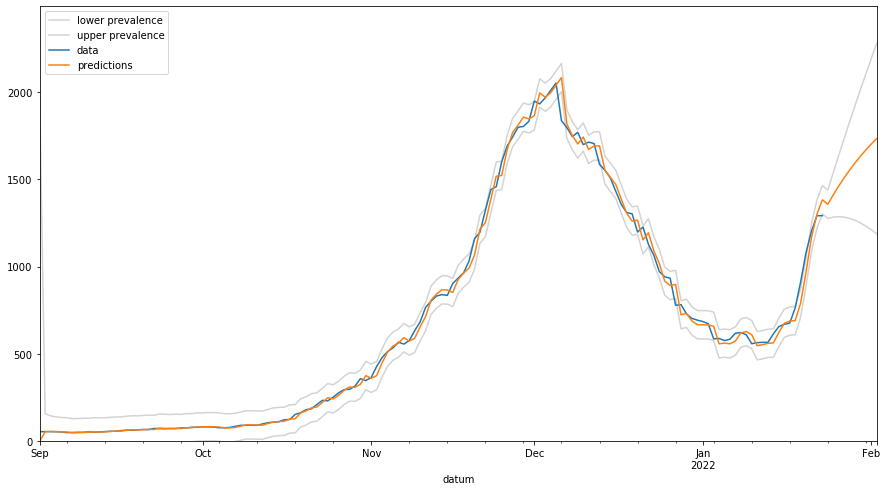

In [35]:
preds = res.get_prediction(end='2022-02-02')
ci = preds.conf_int()

fig = ci.plot(color='lightgrey', figsize=(15, 8))
res.data.orig_endog.plot(label='data', fig=fig)
preds.predicted_mean.plot(label='predictions', fig=fig)
plt.legend()
plt.gca().set_ylim(bottom=0)
plt.show()

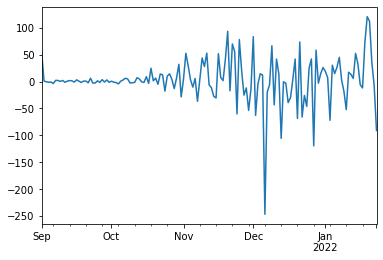

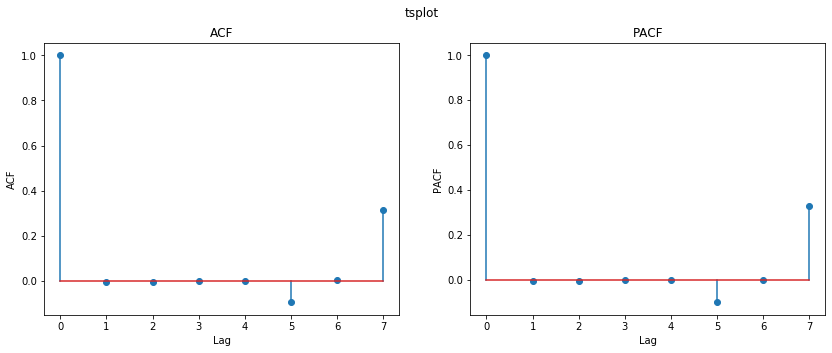

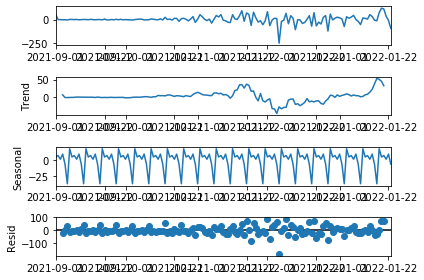

Suma kvadrátů reziduí ACF: 1.1070353387207903


In [57]:
resid = res.data.orig_endog - preds.predicted_mean
resid = resid[:res.data.orig_endog.last_valid_index()]

resid.plot()
sum_of_squares_resid_acf = tsplot(resid)
seasonal_dc(resid, 7)
print('Suma kvadrátů reziduí ACF:', sum_of_squares_resid_acf)

Figure(576x576)


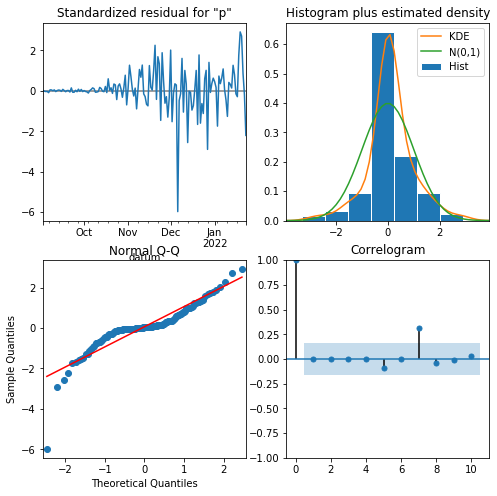

In [59]:
print(res.plot_diagnostics(figsize=(8,8)))

In [93]:
pm.auto_arima(df['2021-09-01':], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=7,
                             start_P=0, seasonal=True,
                             d=1, trace=False,
                             information_criterion='bic',
                             stepwise=True)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(1, 0, 0, 7),
      suppress_warnings=True, with_intercept=False)

In [91]:
from statsmodels.tsa.stattools import adfuller, kpss
testdata = difference(df,2)
print(adfuller(testdata))#abych vyvratil potrebuju 3 diferenci
kpss(testdata)

(-2.6177600944079744, 0.08938189073879582, 13, 160, {'1%': -3.4718957209472654, '5%': -2.8797795410156253, '10%': -2.5764947265625}, 1615.5021505687237)


/home/potato/ProgramFiles/Conda/envs/bipyt/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.0709886406949857,
 0.1,
 27,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

                                    SARIMAX Results                                     
Dep. Variable:                       prevalence   No. Observations:                  145
Model:             ARIMA(1, 1, 1)x(2, 0, [], 7)   Log Likelihood                -729.927
Date:                          Sun, 23 Jan 2022   AIC                           1469.853
Time:                                  21:53:45   BIC                           1484.702
Sample:                              09-01-2021   HQIC                          1475.887
                                   - 01-23-2022                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9028      0.054     16.817      0.000       0.798       1.008
ma.L1         -0.6070      0.096     -6.312      0.

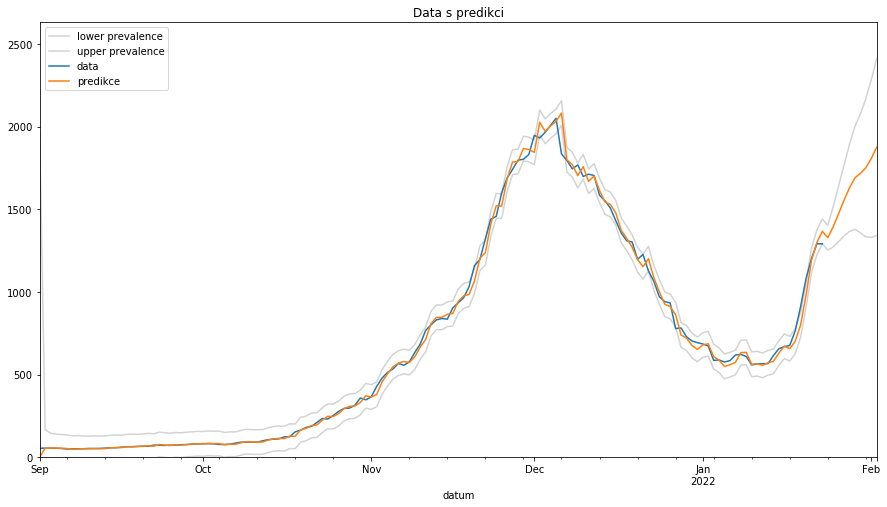

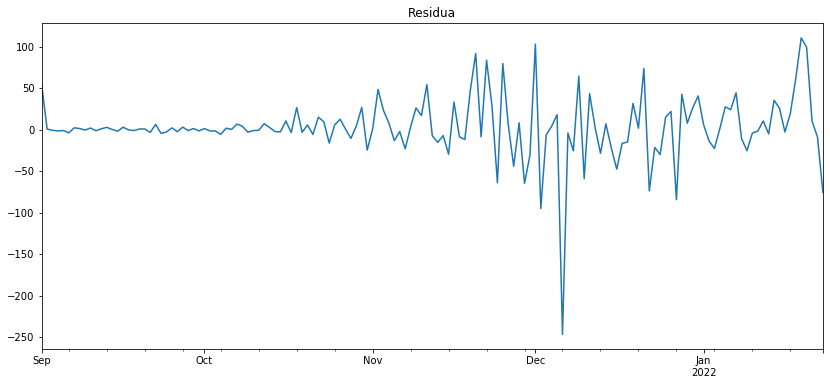

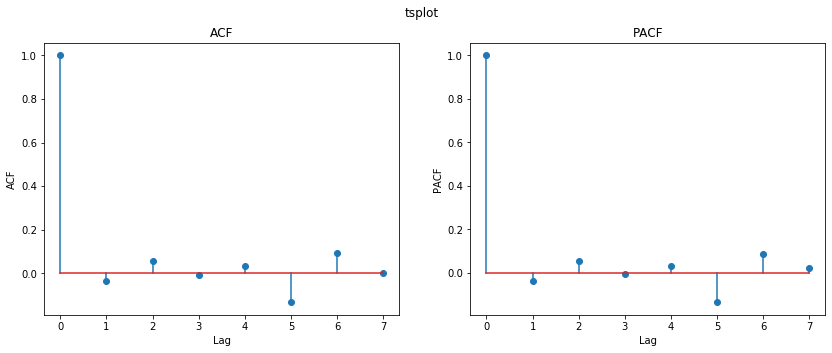

Suma kvadrátů reziduí ACF: 1.031823098940592


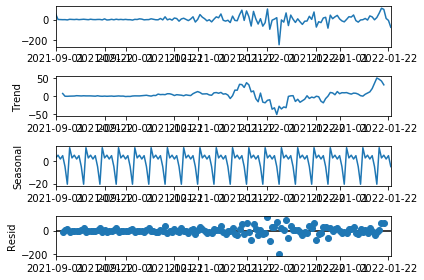

Figure(576x576)


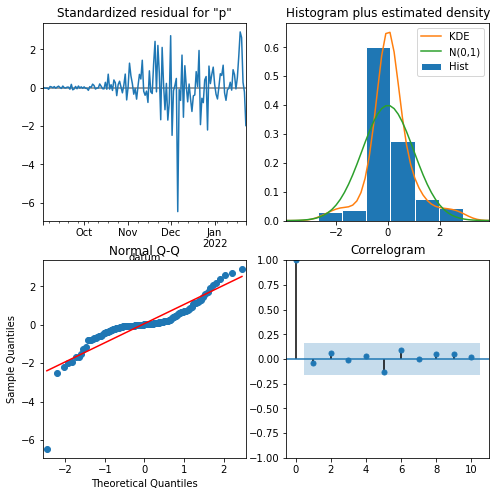

In [71]:
def model_fit(model, end='2022-02-02' ):
    res = model.fit()
    print(res.summary())
    preds = res.get_prediction(end=end)
    ci = preds.conf_int()

    fig = ci.plot(color='lightgrey', figsize=(15, 8))
    res.data.orig_endog.plot(label='data', fig=fig)
    preds.predicted_mean.plot(label='predikce', fig=fig)
    plt.legend()
    plt.gca().set_ylim(bottom=0)
    plt.title("Data s predikci")
    plt.show()
    
    resid = res.data.orig_endog - preds.predicted_mean
    resid = resid[:res.data.orig_endog.last_valid_index()]
    plt.figure(figsize=(14, 6))
    resid.plot()
    plt.title("Residua")
    acf_resid = tsplot(resid)
    print('Suma kvadrátů reziduí ACF:', acf_resid)
    seasonal_dc(resid, 7)
    print(res.plot_diagnostics(figsize=(8,8)))

model_fit(ARIMA(df['2021-09-01':], order=(1,1,1), seasonal_order=(2,0,0,7), trend='n'))
















